# Problem statement

The aim is to develop an algorithm to predict whether a tweet is about a real disaster or not.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
!pip install nltk seaborn

     ---------------------------------------- 1.5/1.5 MB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 288.2/288.2 kB ? eta 0:00:00


In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


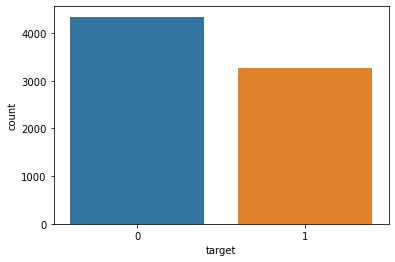

In [3]:
ax = sns.countplot(x="target", data=df)

There is no class imbalance in the distribution of target variable.

# Data Clensing

We are using custom functions to perform the following tasks. Cleaning up the data for modeling should be carried out carefully and with the help of subject matter experts, if possible. This cleaning is done completely based on observation, and can not be considered as a generic preprocessing step for all the NLP tasks. This preprocessing function ensures:

* Removing urls from tweet
* Removing html tags
* Removing punctuations
* Removing stopwords
* Removing emoji
* Lemmatization

In [4]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [5]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
 
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,", people receive wildfire evacuation order cal...",1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


# Words to vectors

Reference

https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795

https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af

We need to convert the words to numeric representations, to use them as input to our machine learning model. One way to do this is:

## Count Vectorizer
The most basic and naive method of transforming words into vectors by counting occurrence of each word in each document. The output is a document-term matrix with each row representing a document and each column addressing a token (weight assigned to each token based on counting the occurence). 

For example:

In [6]:
sample_corpora = df['text'].iloc[:2].values
sample_corpora

array(['deed reason earthquake may allah forgive u',
       'forest fire near la ronge sask canada'], dtype=object)

In [7]:
count_vectorizer = CountVectorizer()
wm = count_vectorizer.fit_transform(sample_corpora)

doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
feat_names = count_vectorizer.get_feature_names()


sample_df = pd.DataFrame(data=wm.toarray(), index=doc_names,columns=feat_names)
sample_df

,allah,canada,deed,earthquake,fire,forest,forgive,la,may,near,reason,ronge,sask
Doc0,1,0,1,1,0,0,1,0,1,0,1,0,0
Doc1,0,1,0,0,1,1,0,1,0,1,0,1,1


## TF-IDF Vectorizer

Taking only word count in document have certain drawbacks. The presence of frequent word vectors wont be sparse (espicially stopwords), though the word may not be important. Also, rare words looks very sparse, hence less importance. To tackle these problems, we use TF-IDF vectorization. 

The first part is **TF**, called term frequency. This simply means the number of times the word occur in document divided by the total number of words in the document. 

The second part is **IDF**, which stands for ‘inverse document frequency’, interpreted like inversed number of documents, in which the term we’re interested in occurs.

**$tf(t,d)$**  is the term frequency is the number of times the term appears in the document.

**$$tf(t,d) = {n_{t,d} \over \sum_{{k \in d}} n_{k,d}} $$**


Where, $t$ is term and $d$ document.


**$idf(t,D)$** is the document frequency is the number of documents '**d**' that contain term '**t**'.

**$$idf(t,D) = {log {N\over{n_t}}}$$**

**$$d \in D, t \in d $$**


where **$N$** is the total number of documents and **$n_t$** is the number of documents containing the term $t$.

The **TF-IDF** vector,

**$$tfidf(t,d,D) = tf(t,d) * idf(t,D)$$**


### Smoothing

An idf is constant per corpus for a word. A smoothened version, adding 1 to denominator is applied to avoid division by 0 (occurs when term is not present in corpora). The idea of idf is to weight down the frequent terms while scale up the rare ones, assuming more frequent ones are not always important ones. So, smoothened idf equation is:

**$$idf(t,D) = {log {N\over{1 + n_t}}}$$**

NB : smoothing is set True as default in scikit learn tfidf vectorizer

# TF-IDF Vectorization using scikit learn

We will split the data to train and test set. In production, we may face out of vocabulary (OOV) words, so we need to account for that too while evaluating the model in test set. Hence we use training data to built vocabulory for tfidf vectorization.

Tfidf vectorization can be implemented easily using scikit learn.

Ref - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [8]:
X_train, X_test , y_train, y_test = train_test_split(df['text'].values,df['target'].values,test_size=0.2,random_state=123,stratify=df['target'].values)

In [9]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

# Random Forest classifier

A basic random forest model is used for classification problem.

In [10]:
classifier = RandomForestClassifier()

classifier.fit(tfidf_train_vectors,y_train)

RandomForestClassifier()

In [11]:
y_pred = classifier.predict(tfidf_test_vectors)

In [12]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       869
           1       0.83      0.63      0.72       654

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523



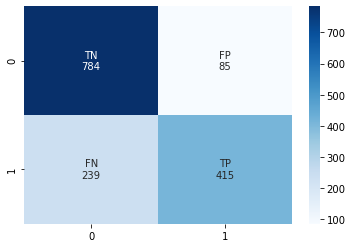

In [13]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

# End Notes

This is a beginer level notebook for the scikit learn based implementation of tfidf vectorization. The accuracy can be improved by using dense vectors like Word2Vec, Glove etc. , that accounts the semantic relationship between the words. Also, the problem can be treated as a sequential learning problem, and can use deep learning techniques.

Link of my work on the same is provided below:

https://www.kaggle.com/neerajmohan/bidirectional-lstm-using-tensorflow-2-0
